In [3]:
import os, sys, re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from os.path import join, exists

In [4]:
def average_df(df):
    exp_list = get_expname_and_number(list(df["expname"]))
    categories = ["accuracy_3s", "accuracy_10s", "accuracy_30s",
                     "c_primary_3s", "c_primary_10s", "c_primary_30s"]
    avg_categories = get_mean_std_category_list(categories)
    df_results = pd.DataFrame(columns=["expname", "length"] + avg_categories)
    for i, exps in enumerate(exp_list):
        expname = exps[0]
        length = get_length_from_expname(expname)
        df_results.loc[i] = [expname, length ,-1, -1, -1, -1, -1, -1, 
                             -1, -1, -1, -1, -1, -1]
        for category in categories:
            indices = []
            for exp in exps:
                idx = df[df["expname"] == exp].index[0]
                indices.append(idx)
            vals = list(df[category].loc[indices])
            vals = list(extract_nums(vals))
            mean = np.mean(vals)
            std = np.std(vals)
            df_results["mean_" + category].loc[i] = mean
            df_results["std_" + category].loc[i] = std
    df_results = df_results.sort_values("length")
    df_results = df_results.reset_index(drop=True)
    return df_results
            
def extract_nums(vals):
    for item in vals:
        try:
            yield float(item)
        except ValueError:
            pass
        
def get_length_from_expname(expname):
    if expname[-2] == "_":
        string = expname[:-2]
    else:
        string = expname
    return [int(s) for s in string.split("_") if s.isdigit()][0]
        
def get_mean_std_category_list(categories):
    list_out = []
    for cat in categories:
        list_out.append("mean_" + cat)
        list_out.append("std_" + cat)
    return list_out
    
def get_expname_and_number(expnames):
    exp_list = []
    found_names = []
    counts = []
    for exp in expnames:
        if exp[-2] == "_":
            name = exp[:-2]
        else:
            name = exp
        if name not in found_names:
            found_names.append(name)
            counts.append(1)
        else:
            idx = found_names.index(name)
            counts[idx] += 1
    for idx, name in enumerate(found_names):
        count = counts[idx]
        name_list = [name]
        if count > 1:
            for i in range(2, count + 1):
                new_name = name + "_" + str(i)
                name_list.append(new_name)
        exp_list.append(name_list)
    return exp_list

def setup_set(df, rirs, speed, clean):
    df_set = df[(df.rirs == rirs)
                & (df.speed_augmentation == speed)
                & (df.clean == clean)]
    df_set.reset_index(drop=True, inplace=True)
    return average_df(df_set)

def setup_data():

    da_summary = pd.read_csv(join(os.getcwd(), "results", "da_summary.csv"))

    baseline_results = da_summary[da_summary["baseline"] == True]
    avg_baseline = average_df(baseline_results)
    avg_baseline = avg_baseline.sort_values("length")

    avg_rirs = setup_set(da_summary, True, False, False)
    avg_rirs_clean = setup_set(da_summary, True, False, True)
    avg_aug = setup_set(da_summary, False, True, False)
    avg_aug_clean = setup_set(da_summary, False, True, True)
    avg_aug_rirs = setup_set(da_summary, True, True, False)
    avg_aug_rirs_clean = setup_set(da_summary, True, True, True)
    
    return avg_baseline, avg_rirs, avg_rirs_clean, avg_aug, avg_aug_clean, avg_aug_rirs, avg_aug_rirs_clean

def convert_category_to_label(category):
    if category == "accuracy":
        return "Accuracy"
    elif category == "c_primary":
        return "$C_{primary}$"

In [5]:
baseline, rirs, rirs_clean, aug, aug_clean, aug_rirs, aug_rirs_clean = setup_data()

/home/paul/miniconda3/envs/lid/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


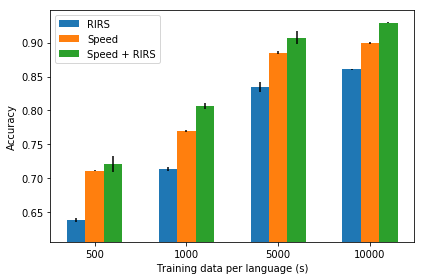

In [29]:
def plot_compare(df_1, df_2, df_3, time, category, 
                 label_1, label_2, label_3,
                 savename=None, cmap=None, legend_loc="best", size=(5,3)):
    assert len(df_1) > 0, "Augmented dataframe is empty"
    assert len(df_2) > 0, "Clean dataframe is empty"
    assert len(df_3) > 0, "Baseline dataframe is empty"
    assert len(df_1) == len(df_2) and len(df_3) == len(df_2), \
            "Dataframe lengths do not match"
    mean_str = "mean_" + category + "_" + str(time) + "s"
    std_str = "std_" + category + "_" + str(time) + "s"
    data_1 = list(df_1[mean_str])
    data_2 = list(df_2[mean_str])
    data_3 = list(df_3[mean_str])
    aug_errs = list(df_1[std_str])
    clean_errs = list(df_2[std_str])
    baseline_errs = list(df_3[std_str])
    
    min_data = min([min(data_1), min(data_2), min(data_3)])
    max_data = max([max(data_1), max(data_2), max(data_3)])
    bottom_padding = min_data * 0.05
    top_padding = max_data * 0.02
    
    bar_width = 0.2
    r1 = np.arange(len(data_1))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]
    
    plt.figure(figsize=size)
    plt.bar(r1, data_1, yerr=baseline_errs, 
            width=bar_width, label=label_1)
    plt.bar(r2, data_2, yerr=clean_errs, 
            width=bar_width, label=label_2)
    plt.bar(r3, data_3, yerr=aug_errs, 
            width=bar_width, label=label_3)
    
    if category == "accuracy":
        plt.ylim((min_data - bottom_padding, max_data + top_padding))
    else:
        plt.ylim((0, max_data + top_padding))
    plt.legend(loc=legend_loc)
        
    plt.xlabel("Training data per language (s)")
    plt.ylabel(convert_category_to_label(category))
    
    x_tick_labels = ["500", "1000", "5000", "10000"]
    plt.xticks(r2, x_tick_labels)
    
    plt.tight_layout()
    if savename is not None:
        plt.savefig(savename + ".pdf", bbox_inches="tight")

"""
plot_compare(rirs, rirs_clean, baseline, 30, 
        "c_primary", "RIRS", "Clean", "Baseline", 
        savename="da_rirs_30")
plot_compare(aug, aug_clean, baseline, 30, 
             "c_primary", "Speed", "Clean", "Baseline", 
             savename="da_aug_30")   
plot_compare(aug_rirs, aug_rirs_clean, baseline, 30, 
             "c_primary", "Speed + RIRS", "Clean", "Baseline", 
             savename="da_aug_rirs_30")
plot_compare(rirs, aug, aug_rirs, 30, 
             "c_primary", "RIRS", "Speed", "Speed + RIRS", 
             savename="da_comparison_30", size=(6,4))
"""
"""
plot_compare(rirs, rirs_clean, baseline, 30, 
             "accuracy", "RIRS", "Clean", "Baseline", 
             savename="da_rirs_acc_30")
plot_compare(aug, aug_clean, baseline, 30, 
             "accuracy", "Speed", "Clean", "Baseline", 
             savename="da_aug_acc_30")   
plot_compare(aug_rirs, aug_rirs_clean, baseline, 30, 
             "accuracy", "Speed + RIRS", "Clean", "Baseline", 
             savename="da_aug_rirs_acc_30")
"""
cmap = "Pastel1"
plot_compare(rirs, aug, aug_rirs, 30, 
             "accuracy", "RIRS", "Speed", "Speed + RIRS", 
             savename="da_comparison_acc_30", size=(6,4),
            cmap=cmap)
